#Gradient Boosting

$$
a(x) = b_0(x)+\eta\sum_{n=1}^N \gamma_n b_n(x) = b_0(x) + \eta \gamma_1 b_1(x) +\ldots + \eta \gamma_N b_N(x)
$$

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.datasets import make_classification

In [ ]:
# Generate synthetic dataset with 2 classes
#X, y = make_classification(n_samples=300, n_features=2, n_redundant=0, random_state=31)
from sklearn.datasets import make_moons
X, y = make_moons(n_samples=200, noise=0.1)
y = (y-0.5)*2

In [ ]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(
         X, y, test_size=0.33, random_state=42)

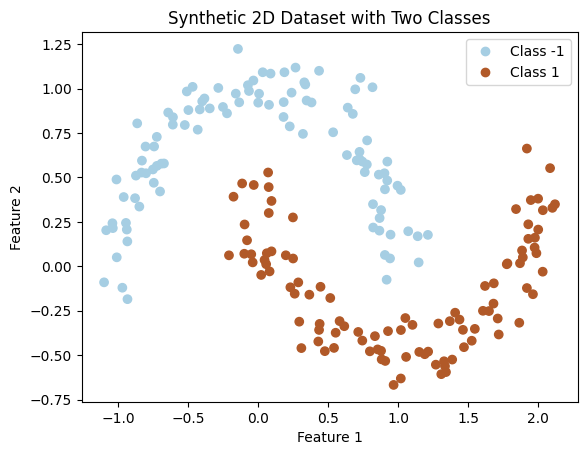

In [ ]:
# Plot the synthetic dataset
scatter = plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.Paired)
plt.xlabel('Feature 1')
plt.ylabel('Feature 2')
plt.title('Synthetic 2D Dataset with Two Classes')
plt.legend(handles=scatter.legend_elements()[0], labels=['Class -1', 'Class 1'])
#plt.savefig('class.jpg')

Because we want to use log-loss
$$
L(y, a(x)) = \log\left( 1+ e^{-y d(x)}\right),
$$
$$
a(x)  = \operatorname{sign} d(x),
$$
we use regression tree.

In [ ]:
from sklearn.tree import DecisionTreeRegressor #DecisionTreeClassifier
b_0 = DecisionTreeRegressor(max_depth=1) #, random_state=0)

In [ ]:
b_0.fit(X_train,y_train)

DecisionTreeRegressor(max_depth=1)

In [ ]:
def loss(y,d):
  return np.log(1+np.exp(-y*d)).mean()

In [20]:
y_pred_0 = b_0.predict(X_train)

In [ ]:
loss(y_test, b_0.predict(X_test))

0.4786022554834492

The target for $b_1(x)$ is
$$
s = -\frac{\partial L}{\partial d} = \frac{-ye^{-yd_0}}{1+e^{-yd_0}}
$$

In [17]:
def loss_grad(y, d):
  return -y/(1+np.exp(y*d))

In [29]:
y_train_1 = -loss_grad(y_train, y_pred_0)

In [30]:
b_1 = DecisionTreeRegressor(max_depth=1)
b_1.fit(X_train, y_train_1)

DecisionTreeRegressor(max_depth=1)

Now we can choose $\gamma_1,$ such that
$$
\sum_{i=1}^N L\left(y^{(i)}, b_0(x^{(i)})+\gamma_1 b_1(x^{(i)})\right)\to \min
$$

In [31]:
y_pred_1 = b_1.predict(X_train)

In [60]:
gammas = np.arange(0,1.01,0.01)
g_best = 0
for g in gammas:
  if loss(y_train, y_pred_0+g*y_pred_1) < loss(y_train, y_pred_0+g_best*y_pred_1):
    g_best = g
g_best

1.0

In [61]:
loss(y_test, b_0.predict(X_test)+g_best*b_1.predict(X_test))

0.4464070458716835

In [62]:
y_pred = (b_0.predict(X_test)+g_best*b_1.predict(X_test) > 0).astype(int)

In [63]:
1-np.mean((y_test+1)/2-y_pred)

0.9242424242424242

In [64]:
import lightgbm as lgb

In [65]:
import pandas as pd

In [123]:
housing = pd.read_csv("https://raw.githubusercontent.com/ageron/handson-ml2/master/datasets/housing/housing.csv")
housing.head()

,longitude,latitude,housing_median_age,total_rooms,total_bedrooms,population,households,median_income,median_house_value,ocean_proximity
0,-122.23,37.88,41.0,880.0,129.0,322.0,126.0,8.3252,452600.0,NEAR BAY
1,-122.22,37.86,21.0,7099.0,1106.0,2401.0,1138.0,8.3014,358500.0,NEAR BAY
2,-122.24,37.85,52.0,1467.0,190.0,496.0,177.0,7.2574,352100.0,NEAR BAY
3,-122.25,37.85,52.0,1274.0,235.0,558.0,219.0,5.6431,341300.0,NEAR BAY
4,-122.25,37.85,52.0,1627.0,280.0,565.0,259.0,3.8462,342200.0,NEAR BAY


In [124]:
housing.dropna(inplace=True)

In [125]:
y = housing['median_house_value']
housing.drop(columns=['median_house_value'], inplace=True)

In [126]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(housing, y, test_size=0.2, random_state=42)

In [127]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer
transform = ColumnTransformer([('OneHot', OneHotEncoder(drop='first'), ['ocean_proximity'])], remainder='passthrough')
transform.fit(X_train)
X_train_hot = pd.DataFrame(transform.transform(X_train), columns=transform.get_feature_names_out())
X_test_hot = pd.DataFrame(transform.transform(X_test), columns=transform.get_feature_names_out())
X_train_hot.head()

,OneHot__ocean_proximity_INLAND,OneHot__ocean_proximity_ISLAND,OneHot__ocean_proximity_NEAR BAY,OneHot__ocean_proximity_NEAR OCEAN,remainder__longitude,remainder__latitude,remainder__housing_median_age,remainder__total_rooms,remainder__total_bedrooms,remainder__population,remainder__households,remainder__median_income
0,0.0,0.0,0.0,0.0,-121.80,37.32,14.0,4412.0,924.0,2698.0,891.0,4.7027
1,1.0,0.0,0.0,0.0,-119.63,36.64,33.0,1036.0,181.0,620.0,174.0,3.4107
2,1.0,0.0,0.0,0.0,-118.06,34.12,25.0,3891.0,848.0,1848.0,759.0,3.6639
3,0.0,0.0,0.0,0.0,-118.31,34.07,28.0,2362.0,949.0,2759.0,894.0,2.2364
4,0.0,0.0,0.0,1.0,-117.27,33.04,27.0,1839.0,392.0,1302.0,404.0,3.5500


In [128]:
gb = lgb.LGBMRegressor(num_leaves=31, learning_rate=0.2, n_estimators=100) #, reg_alpha=0.1, reg_lambda=0.1

In [129]:
gb.fit(X_train_hot, y_train, eval_set=[(X_train_hot, y_train),(X_test_hot, y_test)]) #early_stopping_rounds=6

[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Warning] Auto-choosing col-wise multi-threading, the overhead of testing was 0.001563 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1844
[LightGBM] [Info] Number of data points in the train set: 16346, number of used features: 11
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Start training from score 206644.400098


LGBMRegressor(learning_rate=0.2)

In [130]:
gb.score(X_test_hot, y_test)

0.8326093701460557

<Axes: title={'center': 'Metric during training'}, xlabel='Iterations', ylabel='l2'>

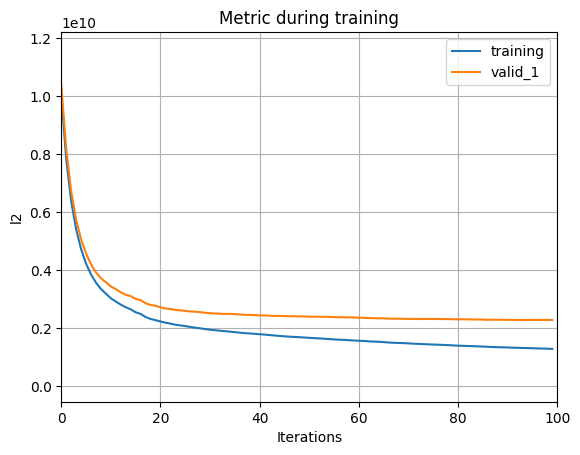

In [131]:
lgb.plot_metric(gb)

<Axes: title={'center': 'Feature importance'}, xlabel='Feature importance', ylabel='Features'>

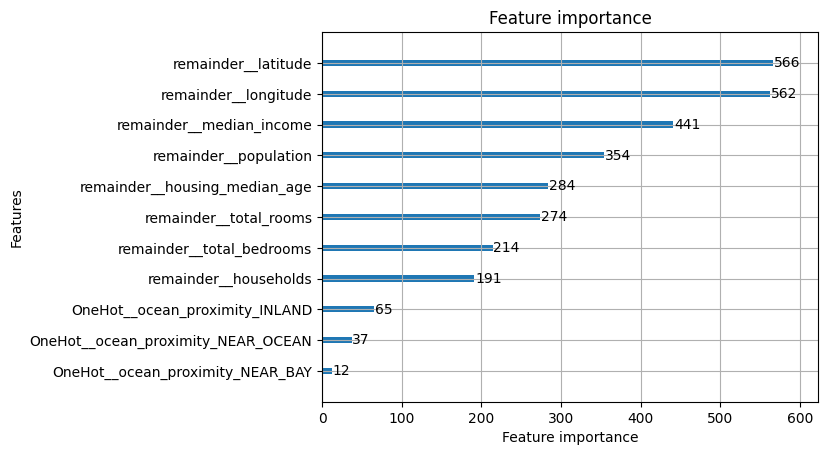

In [132]:
lgb.plot_importance(gb)

#Stacking

In [133]:
y_pred_1 = gb.predict(X_train_hot)

In [155]:
import xgboost as xgb
from xgboost.sklearn import XGBRegressor

In [156]:
xb = XGBRegressor()

In [157]:
xb.fit(X_train_hot, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=None, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=None, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=None, n_jobs=None,
             num_parallel_tree=None, random_state=None, ...)

In [158]:
y_pred_2 = xb.predict(X_train_hot)

In [159]:
xb.score(X_test_hot, y_test)

0.8313191632896539

In [165]:
from sklearn.linear_model import LinearRegression

In [166]:
super_model = LinearRegression()

In [167]:
super_model.fit(np.vstack((y_pred_1, y_pred_2)).reshape(2,-1).T, y_train)

LinearRegression()

In [168]:
from sklearn.metrics import r2_score

In [169]:
super_model.score(np.vstack((gb.predict(X_test_hot), xb.predict(X_test_hot))).reshape(2,-1).T, y_test)

0.8224267113632173